# 1. Loading Packages 

In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer # VADER for sentiment
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# One-time downloads for NLTK (if you haven't done them)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4') # For WordNetLemmatizer
# nltk.download('vader_lexicon') # For VADER

# 2. Loading data

In [3]:
# Load dataset
try:
    df = pd.read_csv("../data/amazon_books_reviews.csv")
except FileNotFoundError:
    print("Error: amazon_books_reviews.csv not found. Please check the path.")
    exit()

In [4]:

# Display basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rating             10000 non-null  float64
 1   title              10000 non-null  object 
 2   text               10000 non-null  object 
 3   images             10000 non-null  object 
 4   asin               10000 non-null  object 
 5   parent_asin        10000 non-null  object 
 6   user_id            10000 non-null  object 
 7   timestamp          10000 non-null  int64  
 8   helpful_vote       10000 non-null  int64  
 9   verified_purchase  10000 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 713.0+ KB
None


In [5]:
display(df)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1.0,Not a watercolor book! Seems like copies imo.,It is definitely not a watercolor book. The p...,[{'small_image_url': 'https://m.media-amazon.c...,B09BGPFTDB,B09BGPFTDB,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1642399598485,0,True
1,5.0,Updated: after 1st arrived damaged this one is...,Updated: after first book arrived very damaged...,[],0593235657,0593235657,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640629604904,1,True
2,5.0,Excellent! I love it!,I bought it for the bag on the front so it pai...,[],1782490671,1782490671,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640383495102,0,True
3,5.0,Updated after 1st arrived damaged. Excellent,Updated: after 1st arrived damaged the replace...,[],0593138228,0593138228,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1640364906602,0,False
4,5.0,Beautiful patterns!,I love this book! The patterns are lovely. I ...,[{'small_image_url': 'https://m.media-amazon.c...,0823098079,0823098079,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1637312253230,0,True
...,...,...,...,...,...,...,...,...,...,...
9995,5.0,A well researched book of facts and accomplish...,"This book is a short, compressed look at the l...",[],0894906844,0894906844,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1574825806573,0,False
9996,5.0,An enjoyable book of wisdom and encouragement,This is a charming book written by a smart wom...,[],B07KB65NMS,B07KB65NMS,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1574655470598,0,False
9997,5.0,An enchanting book,I completely enjoyed this short look into the ...,[],0812989341,0812989341,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1572295102752,0,False
9998,5.0,Amazing detail and a bounty of information,This is a great deal of necessary information ...,[],0807858838,0807858838,AFQ7WYW4KSH4VI5OVXCP2GV6PBRA,1571006381867,4,False


In [6]:
# check missing values
print(df.isnull().sum())
# check the distribution of the ratings
print(df['rating'].value_counts().sort_index())


rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64
rating
1.0     150
2.0     360
3.0    1066
4.0    2597
5.0    5827
Name: count, dtype: int64


There **no missing value** in this dataset.

## 3. Data preparation

In [7]:
df.dropna(subset=['text', 'rating'], inplace=True) # Ensure 'text' and 'rating' are not NaN

# Filter for 1-star and 5-star reviews
df_1_star = df[df['rating'] == 1.0].copy()
df_5_star = df[df['rating'] == 5.0].copy()

print(f"Number of 1-star reviews: {len(df_1_star)}")
print(f"Number of 5-star reviews: {len(df_5_star)}")
# Filter for 1-star and 5-star reviews for the comparative analysis
df_1_5 = df[df['rating'].isin([1, 5])].copy()

Number of 1-star reviews: 150
Number of 5-star reviews: 5827


There is a significant **imbalance** in the amount of data between **1-star reviews (150)** and **5-star reviews (5827)**. This is a very important issue that will directly affect the reliability and interpretability of subsequent analysis results, so the problem of data imbalance needs to be solved later.

## 4. Data Visualization

## 4.1 Distribution of All Book 1-Star and 5-Star Reviews

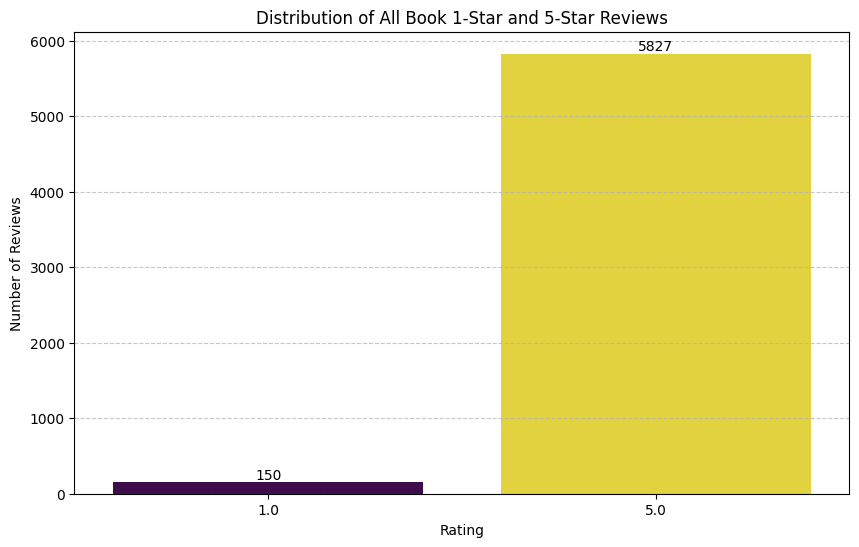

In [8]:
#Visualization 1: Overall Rating Distribution
def plot_rating_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='rating', palette='viridis', order=sorted(df['rating'].unique()), hue = 'rating', legend = False)
    plt.title('Distribution of All Book 1-Star and 5-Star Reviews')
    plt.xlabel('Rating')
    plt.ylabel('Number of Reviews')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # show number on the top of the bar
    for index, value in enumerate(df['rating'].value_counts().sort_index()):
        plt.text(index, value, str(value), ha='center', va='bottom')
    plt.show()

plot_rating_distribution(df_1_5)

The chart's most critical revelation is the significant **class imbalance** within the dataset. While **5-star reviews** are abundant **(5,827)**, **1-star reviews** are comparatively scarce **(150)**. This visual finding is crucial; it directly validates the analytical strategy of using relative frequencies for lexical analysis in this phase and underscores the necessity of the oversampling technique that has been prepared for the modeling phase in Part C.

## 4.2 Sentiment Analysis (VADER)

Shows the distribution of sentiment scores for 1-star and 5-star reviews, quantifying the difference in sentiment intensity


--- Performing Sentiment Analysis with VADER ---
VADER sentiment scores calculated.
         count      mean       std     min       25%     50%     75%     max
rating                                                                      
1.0      150.0 -0.024403  0.658254 -0.9975 -0.618975  0.0000  0.5899  0.9888
5.0     5827.0  0.706285  0.479597 -0.9998  0.648600  0.9217  0.9819  0.9998


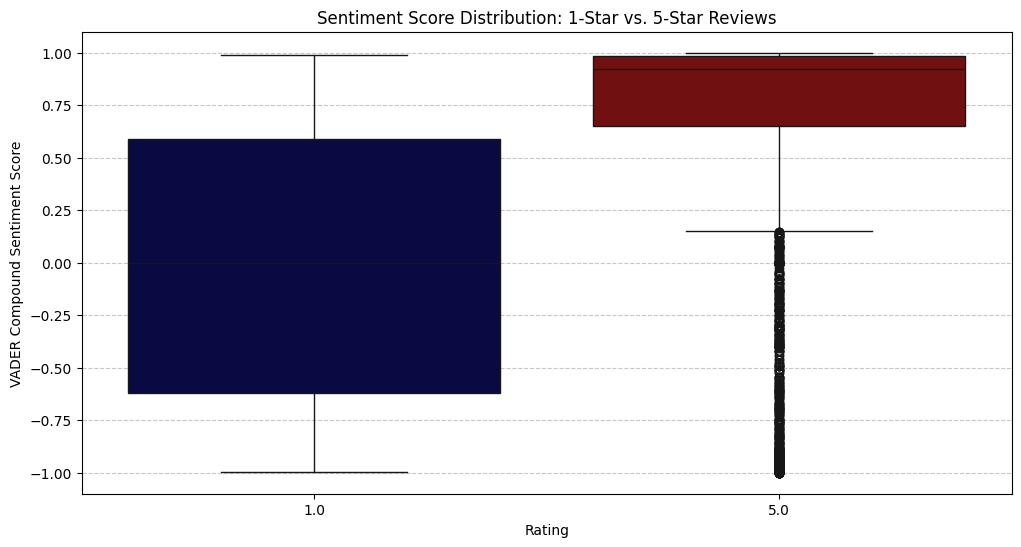

In [9]:
# Sentiment Analysis (VADER)
print("\n--- Performing Sentiment Analysis with VADER ---")
sid = SentimentIntensityAnalyzer()
# VADER works best on raw text with punctuation, so we apply it before text cleaning
df_1_5['sentiment_score'] = df_1_5['text'].apply(lambda text: sid.polarity_scores(str(text))['compound'])
print("VADER sentiment scores calculated.")
print(df_1_5.groupby('rating')['sentiment_score'].describe())

def plot_sentiment_distribution(df):
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='rating', y='sentiment_score', palette='seismic', hue = 'rating', legend = False)
    plt.title('Sentiment Score Distribution: 1-Star vs. 5-Star Reviews')
    plt.xlabel('Rating')
    plt.ylabel('VADER Compound Sentiment Score')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
plot_sentiment_distribution(df_1_5)

The **average sentiment score** of 1-star reviews is much **lower than** that of 5-star reviews. This box plot distribution chart can show the difference more intuitively.This box plot to show the **distribution range**, **median**, and **outliers of sentiment scores** for 1-star and 5-star reviews.

It can be seen that the **1-star** reviews have some **unexpected positive** sentiment expressions, but the **overall negative** sentiment is more. The **5-star** reviews have more **outliers** and are all in the **positive** sentiment expression part.

## 4.3 Data Preprocessing

**Without preprocessing**, the results of word cloud and N-gram analysis will be polluted by **a large number of meaningless words**, and it is **impossible to discover truly valuable patterns** and insights. Therefore, we **need to preprocess the data** before visualizing word clouds and N-grams.

In [ ]:
# nltk.download('punkt_tab')
import re
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Add custom stopwords to filter out noise from n-grams
custom_stopwords = ['book', 'one', 'author','read', 'story','reading','page', 'really', 'time','life', 'also','make','reader','first','would', 'get','way',
                     'say', 'find', 'many','novel','character', 'writing', 'child', 'people', 'could',
                     'chapter', 'year', 'york', 'ago','later', 'receipe']

stop_words.update(custom_stopwords)

#Basic text preprocessing for word cloud generation
def preprocess_text(text):
    if not isinstance(text, str): # Handle potential non-string data
        return ""
    # Lowercase
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    # remove <br />
    text = re.sub(r'<br />', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 1] # len(token) > 1 to remove short tokens
    return " ".join(processed_tokens) # Return as a string for some analyses, or list of tokens

# Apply preprocessing to the 'text' and 'title' column of filtered DataFrames
df_1_5['processed_text'] = df_1_5['text'].apply(preprocess_text) + " " + df_1_5['title'].apply(preprocess_text)

# Combine all preprocessed text for each category
text_1_star = " ".join(review for review in df_1_5[df_1_5['rating'] == 1]['processed_text'])
text_5_star = " ".join(review for review in df_1_5[df_1_5['rating'] == 5]['processed_text'])

print(df_1_5.columns)

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'sentiment_score',
       'processed_text'],
      dtype='object')


##  4.4 Comparative Analysis of High-Frequency Bigrams

Explore common phrases or collocations in 1-star and 5-star reviews to reveal language patterns

Extract common bigrams or trigrams, such as "very disappointed" and "highly recommended".

Draw a bar chart comparing the most common N-grams in 1-star and 5-star reviews.

Identifying common N-grams: N-grams are sequences of words. Identifying common n-grams can give insight into the most common phrases in the dataset.


--- Top 15 Bigrams in 1-Star Reviews ---
                 ngram  count
0          waste money      8
1           didnt like      7
2          spider john      7
3              im sure      6
4          pretty much      6
5          nothing new      5
6       poorly written      5
7             sar work      5
8          despite say      5
9            look like      4
10          seems like      4
11          soap opera      4
12           dont like      4
13      main character      4
14  historical fiction      4

--- Top 15 Bigrams in 5-Star Reviews ---
               ngram  count
0       ross poldark    307
1          five star    248
2   highly recommend    238
3       well written    224
4       good product    165
5       product good    163
6     poldark series    160
7   george warleggan    154
8      twisted sword    152
9    looking forward    140
10       even though    137
11       high school    137
12        dont think    118
13          le saint    111
14      beverly 

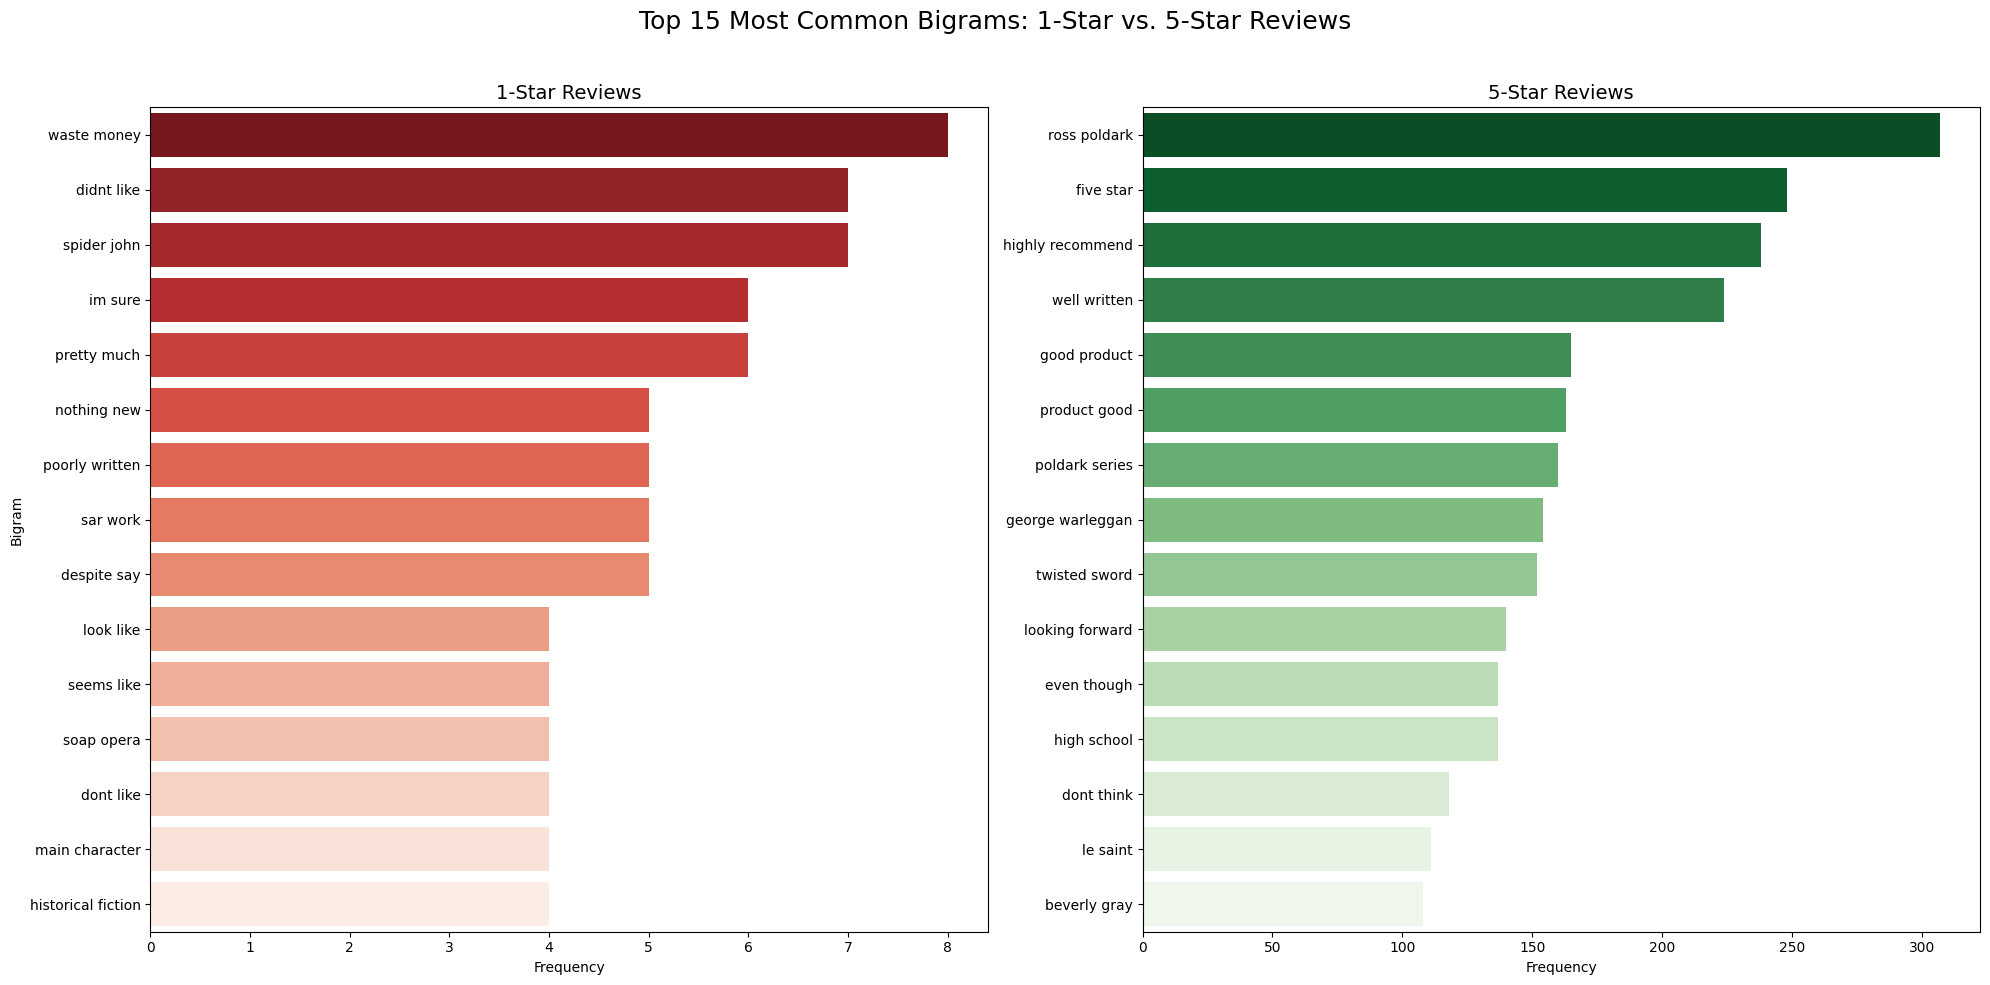

In [11]:
# Get top 15 bigrams from a given text corpus.
def get_top_ngrams(corpus, n=2, top_k=15):
    all_tokens = [token for text in corpus if pd.notna(text) for token in text.split()]
    if not all_tokens:
        return pd.DataFrame(columns=['ngram', 'count'])
    ngram_tuples = nltk.ngrams(all_tokens, n)
    ngram_counts = Counter(ngram_tuples)
    top_ngrams = ngram_counts.most_common(top_k)
    top_ngrams_df = pd.DataFrame(top_ngrams, columns=['ngram', 'count'])
    top_ngrams_df['ngram'] = top_ngrams_df['ngram'].apply(lambda x: ' '.join(x))
    return top_ngrams_df

# Get top 15 bigrams for each category
df_1_star = df_1_5[df_1_5['rating'] == 1]['processed_text']
df_5_star = df_1_5[df_1_5['rating'] == 5]['processed_text']
top_bigrams_1_star = get_top_ngrams(df_1_star, n=2, top_k=15)
top_bigrams_5_star = get_top_ngrams(df_5_star, n=2, top_k=15)

print("\n--- Top 15 Bigrams in 1-Star Reviews ---")
print(top_bigrams_1_star)
print("\n--- Top 15 Bigrams in 5-Star Reviews ---")
print(top_bigrams_5_star)

# Visualization 5: Top 15 Bigrams Comparison
def plot_top_bigrams(top_bigrams_1_star, top_bigrams_5_star):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Top 15 Most Common Bigrams: 1-Star vs. 5-Star Reviews', fontsize=18)

    # Plot for 1-Star Reviews
    if not top_bigrams_1_star.empty:
        sns.barplot(ax=axes[0], x='count', y='ngram', data=top_bigrams_1_star, palette='Reds_r', legend=False, hue = 'ngram')
        axes[0].set_title('1-Star Reviews', fontsize=14)
        axes[0].set_xlabel('Frequency')
        axes[0].set_ylabel('Bigram')

    # Plot for 5-Star Reviews
    if not top_bigrams_5_star.empty:
        sns.barplot(ax=axes[1], x='count', y='ngram', data=top_bigrams_5_star, palette='Greens_r', legend=False, hue = 'ngram')
        axes[1].set_title('5-Star Reviews', fontsize=14)
        axes[1].set_xlabel('Frequency')
        axes[1].set_ylabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_top_bigrams(top_bigrams_1_star, top_bigrams_5_star)

This visualization adds a layer of nuance to our lexical analysis. For **5-star reviews**, it reinforces the **"Praise and Recommendation"** cluster with phrases like **"highly recommend"**. For **1-star reviews**, it provides more specific insights into user **complaints (e.g., "waste money")**, offering more contextual clues than single words alone. It clearly shows how users formulate their praise or criticism, which is a richer finding than simply knowing which words they use.

## 4.5 Visualization Word Cloud for 1-Star Reviews

Show the difference between high-frequency words in 1-star and 5-star reviews, revealing word usage trends.

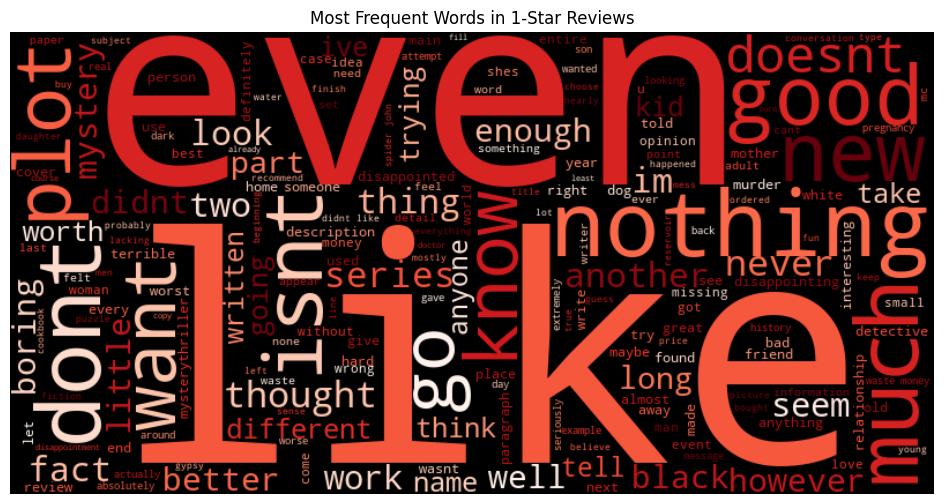

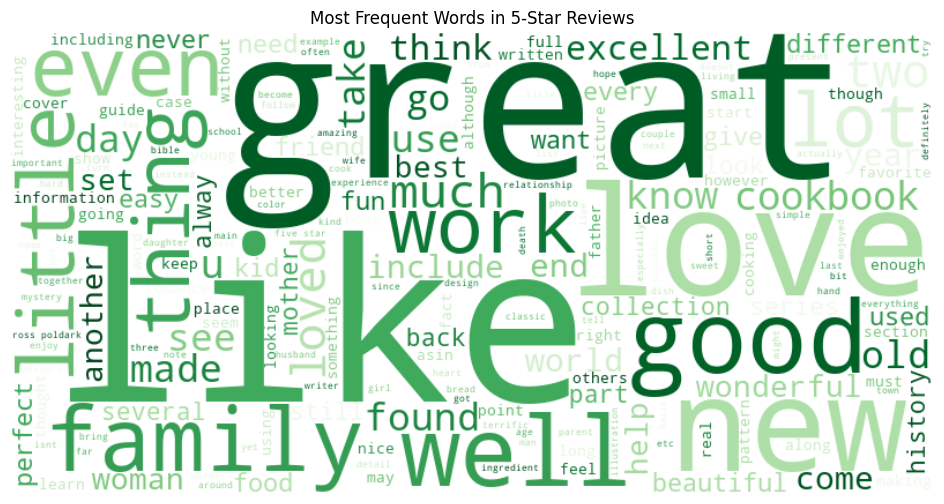

In [14]:
# Visualization Word Cloud for 1-Star Reviews
def plot_word_cloud_1_star(text_1_star):
    wordcloud_1_star = WordCloud(width=800, height=400, background_color='black', colormap='Reds', stopwords=COMMON_STOP_WORDS).generate(text_1_star)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_1_star, interpolation='bilinear')
    plt.axis("off")
    plt.title('Most Frequent Words in 1-Star Reviews')
    plt.show()

# Visualization Word Cloud for 5-Star Reviews
def plot_word_cloud_5_star(text_5_star):
    wordcloud_5_star = WordCloud(width=800, height=400, background_color='white', colormap='Greens', stopwords=COMMON_STOP_WORDS).generate(text_5_star)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud_5_star, interpolation='bilinear')
    plt.axis("off")
    plt.title('Most Frequent Words in 5-Star Reviews')
    plt.show()

# Define common stop words in 1-star and 5-star reviews
COMMON_STOP_WORDS = ['book', 'one', 'author','read', 'story','reading','page', 'really', 'time','life', 'also','make','reader','first','would', 'get','way',
                     'say', 'find', 'many','novel','character', 'writing', 'child', 'people', 'could','recipe',
                     'chapter']

plot_word_cloud_1_star(text_1_star)
plot_word_cloud_5_star(text_5_star)

These images strongly show the "unique word clustering" pattern. The five-star review word cloud is mainly dominated by **praise words ("great", "love", "well")**, while the one-star review word cloud is dominated by **disappointment words ("never", "don't", "nothing")**. This directly confirms qualitatively that the **two groups** of respondents used **different words** to express their opinions.

## Answering questions

* Sentiment score differences: 1-star and 5-star reviews do have significant differences in VADER sentiment scores, with 1-star scoring much lower than 5-star.
* Common vocabulary differences: The word cloud and high-frequency word list show that 1-star reviews are full of words expressing dissatisfaction and disappointment (to name a few), while 5-star reviews are full of words expressing praise, love, and recommendation (to name a few).